### Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '16'  
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf
import h5py

os.chdir('/home/mattho/git/ltu-cmass/matts_tests')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
wdir = '/automnt/data80/mattho/cmass-ili'

## Halo catalog inference

### Load training and test data

In [65]:
def get_cosmo(source_path):
    cfg = OmegaConf.load(join(source_path, 'config.yaml'))
    return np.array(cfg.nbody.cosmo)

def get_halo_Pk(source_path):
    diag_file = join(source_path, 'diag', 'halos.h5')
    if not os.path.exists(diag_file):
        return None, None, None
    with h5py.File(diag_file, 'r') as f:
        a = list(f.keys())[-1]
        k = f[a]['Pk_k'][:]
        Pk = f[a]['Pk'][:]
    cosmo = get_cosmo(source_path)
    return k, Pk, cosmo

In [70]:
# Training suite
suite = '2gpch_0704'
sim = 'borgpm'
L, N = 2000, 256

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0)[:-2]


ktrain, Pktrain, cosmotrain = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_halo_Pk(join(suite_path, lhid))
    ktrain.append(k)
    Pktrain.append(Pk)
    cosmotrain.append(cosmo)

ktrain, Pktrain, cosmotrain = map(lambda x: [i for i in x if i is not None], [ktrain, Pktrain, cosmotrain])
ktrain, Pktrain, cosmotrain = map(np.stack, [ktrain, Pktrain, cosmotrain])
print(ktrain.shape, Pktrain.shape, cosmotrain.shape)

100%|██████████| 1898/1898 [00:43<00:00, 43.89it/s] 

(1093, 221) (1093, 221, 3) (1093, 5)


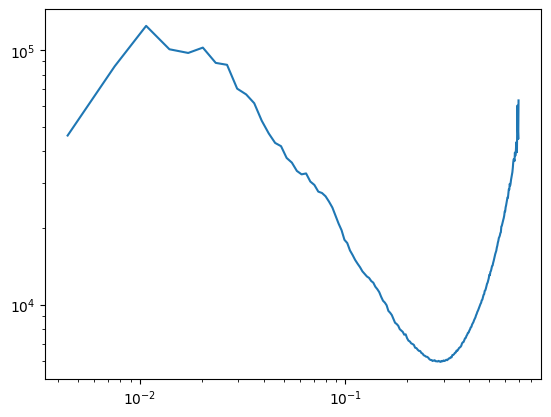

In [72]:
k, Pk, cosmo = get_halo_Pk(join(suite_path, str(100)))
plt.loglog(k, Pk[:,0])

In [95]:
# Test suite
suite = 'abacus'
sim = 'nbody'
L, N = 2000, 256

from cmass.utils import get_source_path

suite_path = get_source_path(wdir, suite, sim, L, N, 0, check=False)[:-2]


ktest, Pktest, cosmotest = [], [], []
for lhid in tqdm(os.listdir(suite_path)):
    k, Pk, cosmo = get_halo_Pk(join(suite_path, lhid))
    ktest.append(k)
    Pktest.append(Pk)
    cosmotest.append(cosmo)

ktest, Pktest, cosmotest = map(lambda x: [i for i in x if i is not None], [ktest, Pktest, cosmotest])
ktest, Pktest, cosmotest = map(np.stack, [ktest, Pktest, cosmotest])
print(ktest.shape, Pktest.shape, cosmotest.shape)

100%|██████████| 52/52 [00:01<00:00, 28.04it/s]

(52, 221) (52, 221, 3) (52, 5)


In [96]:
cosmotest[:,0] /= (cosmotest[:,2]**2)  # correct for h^2
cosmotest[:,1] /= (cosmotest[:,2]**2)  # correct for h^2

/tmp/ipykernel_4132657/1758615995.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


[Text(0.5, 0, 'k'), Text(0, 0.5, 'P(k)')]

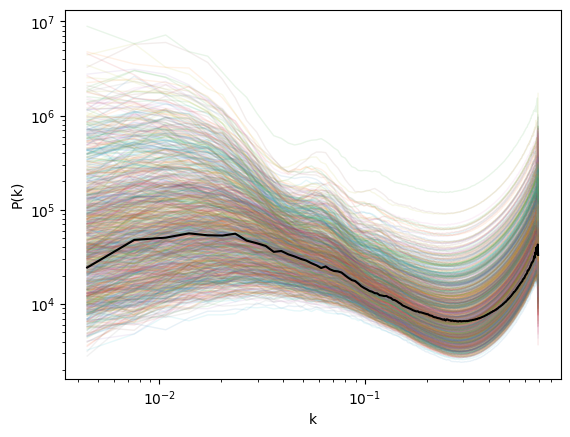

In [75]:
l = 0

f, ax = plt.subplots()
cmap = mpl.cm.get_cmap('viridis')
Om = cosmotrain[:,0]
for k, Pk, cosmo in zip(ktrain, Pktrain[...,0], Om):
    omnorm = (Om-Om.min())/(Om.max()-Om.min())
    ax.loglog(k, Pk, lw=1, alpha=0.1)
ax.loglog(ktest[l], Pktest[l,...,0], 'k')
ax.set(xlabel='k', ylabel='P(k)')

### Train

In [79]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN
device='cpu'

def run_inference(x, theta):
    loader = NumpyLoader(x=x, theta=theta)

    # define a prior
    prior = ili.utils.Uniform(
        low=theta.min(axis=0),
        high=theta.max(axis=0),
        device=device)

    embedding = FCN(n_hidden=[64, 32, 16], act_fn='ReLU')

    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_lampe(
            model='maf', hidden_features=50, num_transforms=5,
            embedding_net=embedding),
        # ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
    ]

    # define training arguments
    train_args = {
        'training_batch_size': 32,
        'learning_rate': 1e-5
    }

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries

In [80]:
# train at different resolutions
kmaxs = [0.2] # [0.1, 0.2, 0.4, 0.6]

# impute with mean
def impute(arr):
    # Compute the mean of each row, ignoring nan values
    col_mean = np.nanmean(arr, axis=1)
    
    # Find the indices where values are nan
    inds = np.where(np.isnan(arr))
    
    # Replace nan values with the mean of the respective column
    arr[inds] = np.take(col_mean, inds[0])
    return arr

In [81]:
posteriors, summaries = {}, {}
for kmax in kmaxs:
    print(f'Training for kmax={kmax}')

    # focus on the monopole
    x = Pktrain[:, :, 0]

    # cut on k
    mask = ktrain[0] < kmax
    x = x[:, mask]
    theta = cosmotrain

    # log
    x = np.log10(x)

    # # impute
    # x = impute(x)

    # train
    _p, _s = run_inference(x, theta)
    posteriors[kmax] = _p
    summaries[kmax] = _s


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


Training for kmax=0.2


1054 epochs [03:14,  5.41 epochs/s, loss=-9.76, loss_val=-9.49]
INFO:root:It took 194.87017011642456 seconds to train models.


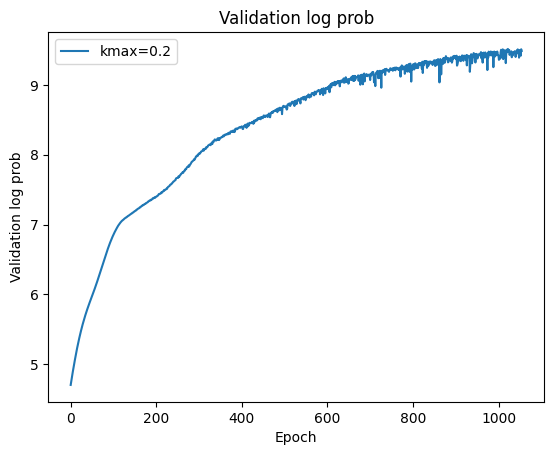

In [82]:
# plot loss functions
f, ax = plt.subplots()
for kmax in kmaxs:
    ax.plot(summaries[kmax][0]['validation_log_probs'], label=f'kmax={kmax}')
ax.set(xlabel='Epoch', ylabel='Validation log prob', title='Validation log prob')
ax.legend()

### Plot

In [89]:
kmax = 0.2
_p = posteriors[kmax]
xobs = Pktest[:, :, 0]
mask = ktest[0] < kmax
xobs = xobs[:, mask]
xobs = np.log10(xobs)
# xobs = impute(xobs)
i = 10
xobs[i], cosmotest[i]

(array([4.19582461, 4.57514433, 4.56068964, 4.63600469, 4.60547241,
        4.61626315, 4.63841629, 4.57058585, 4.54559875, 4.51417441,
        4.45745673, 4.47122381, 4.43965643, 4.41634991, 4.39531005,
        4.37819286, 4.34800616, 4.32646715, 4.29623051, 4.31214494,
        4.28159206, 4.26705919, 4.26349955, 4.25511541, 4.22225651,
        4.20028539, 4.1762178 , 4.16861858, 4.14393823, 4.1154862 ,
        4.09814869, 4.08038749, 4.0613611 , 4.05345433, 4.03725046,
        4.03033131, 4.01060089, 4.00848329, 4.00100618, 4.00210471,
        3.99083919, 3.98281587, 3.96660875, 3.95972647, 3.94986343,
        3.9383651 , 3.92931186, 3.9085694 , 3.90061023, 3.88799596,
        3.88043804, 3.87275608, 3.86265045, 3.85162822, 3.84459492,
        3.838972  , 3.83795501, 3.82524589, 3.82469425, 3.82020658,
        3.81444573, 3.81126964, 3.80690509]),
 array([0.14306 , 0.02096 , 0.6536  , 0.9893  , 0.772033]))

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1495it [00:00, 27301.20it/s]            


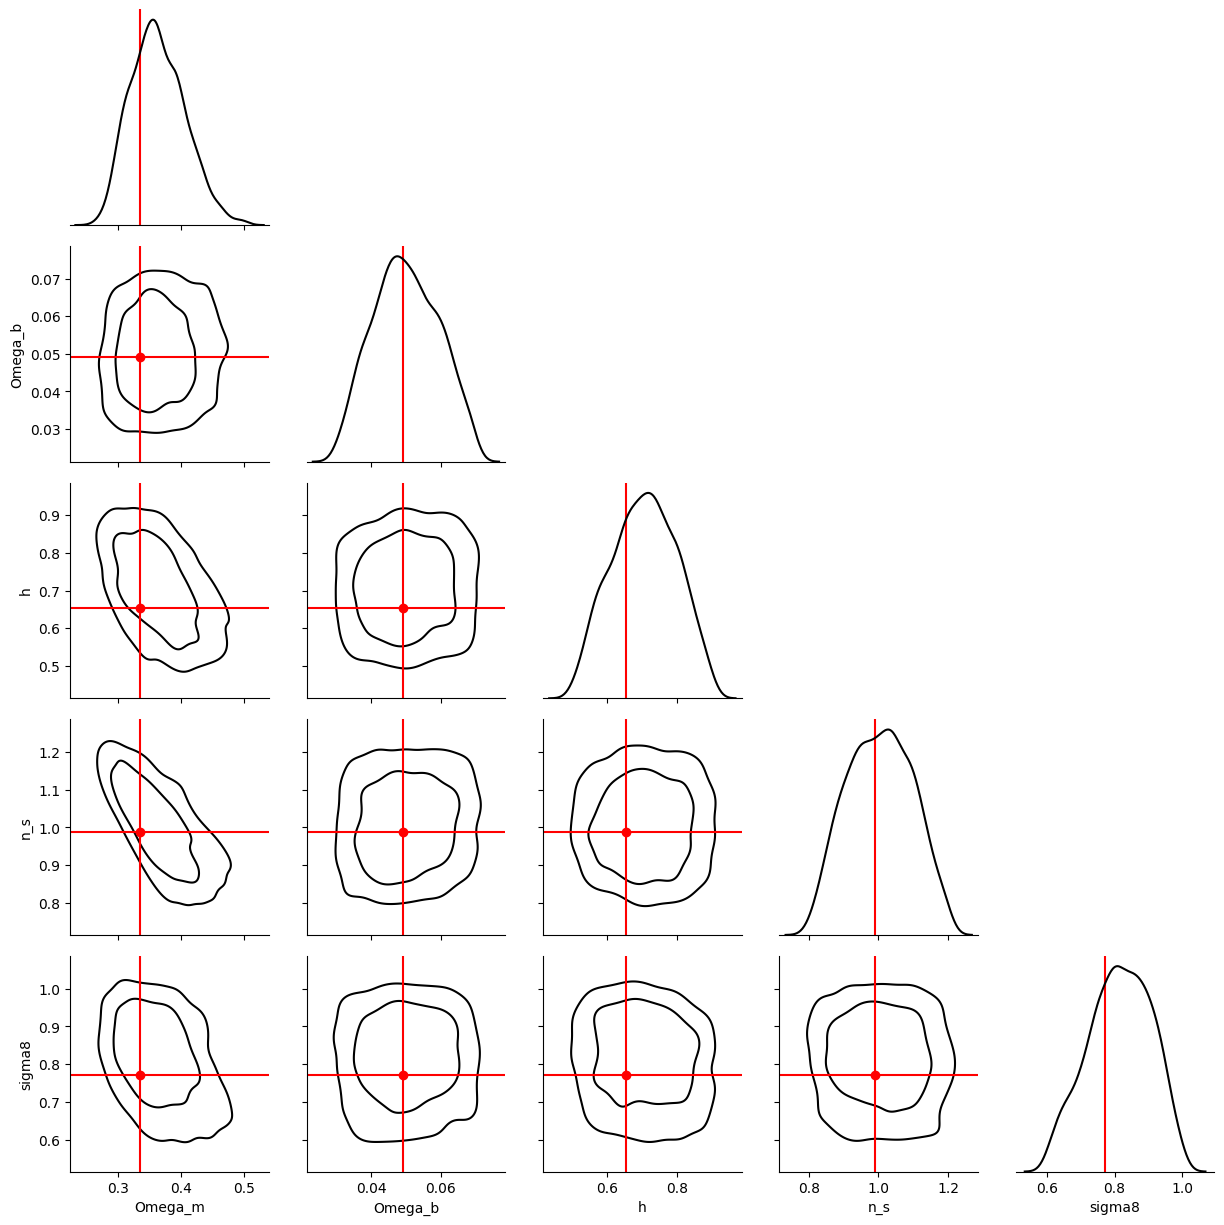

In [98]:
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = metric(
    posterior=_p,
    x_obs = xobs[10], theta_fid = cosmotest[10],
    grid=None,
    name=f'kmax={kmax}'
)

100%|██████████| 52/52 [00:01<00:00, 31.21it/s]
INFO:root:Mean logprob: -7.2255e+01Median logprob: -5.7149e+01
100%|██████████| 100/100 [00:00<00:00, 398.75it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


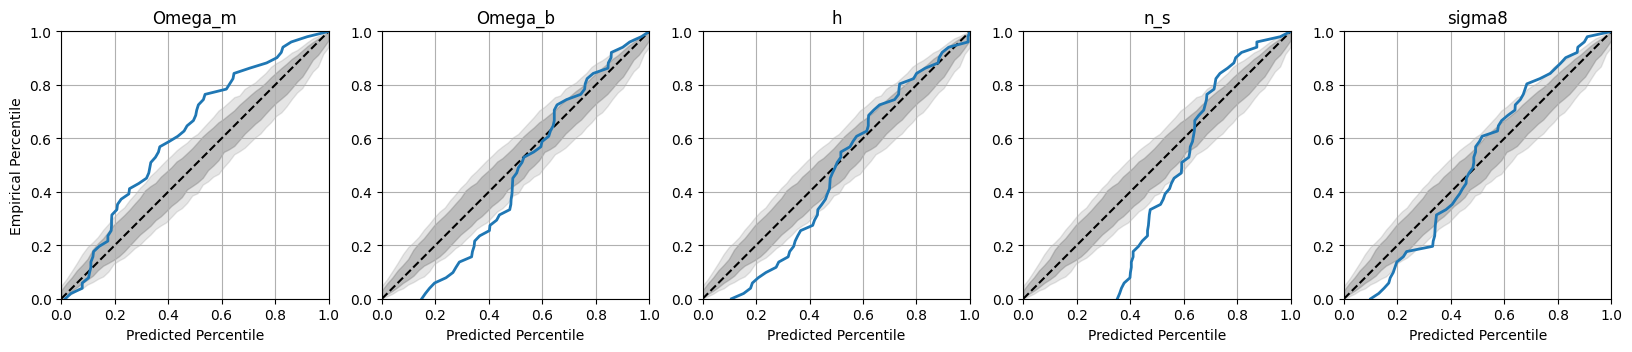

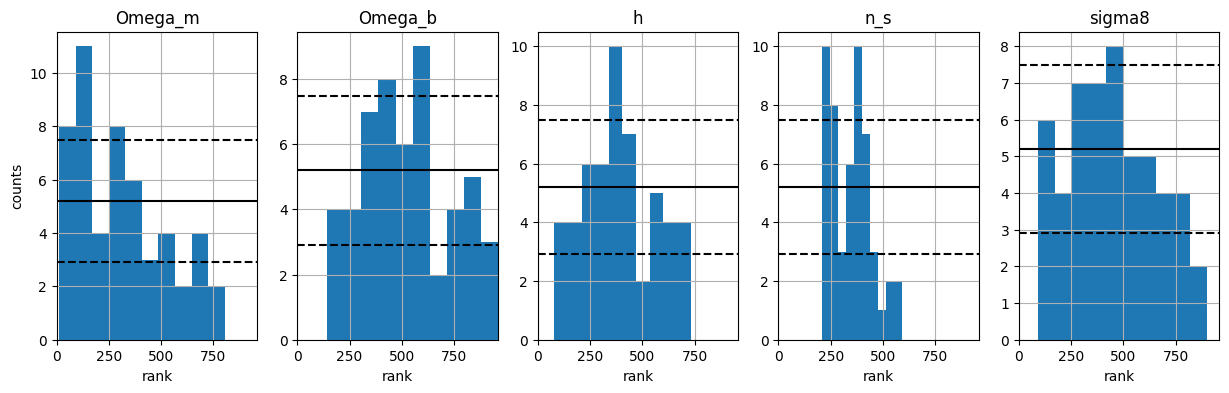

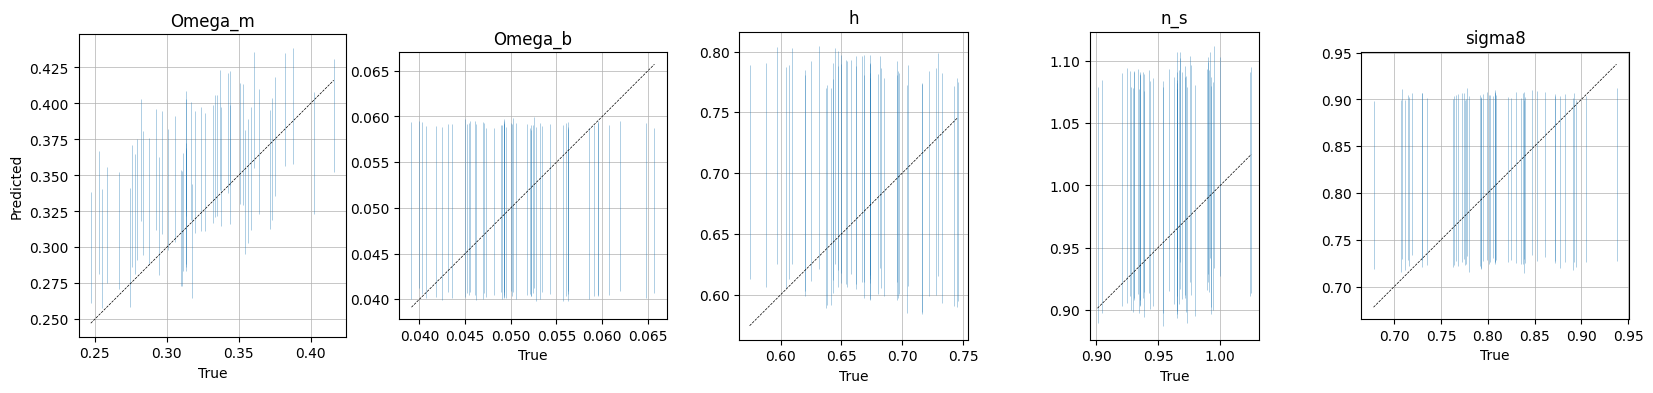

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


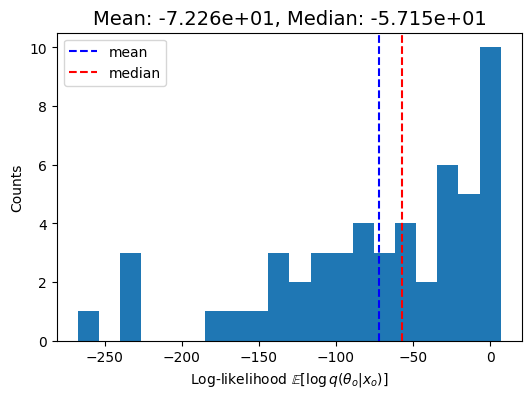

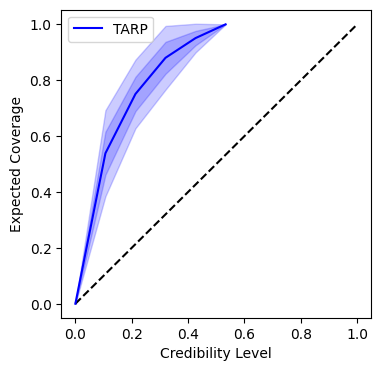

In [97]:
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)
metric(posterior=_p, x=xobs, theta=cosmotest);

## Scratch

### Compare CHARM across cosmologies

In [42]:
charm_path = '/automnt/data80/mattho/cmass-ili/quijotelike/fastpm/L1000-N128'# 
quijote_path = '/automnt/data80/mattho/cmass-ili/quijote/nbody/L1000-N128'

cPks = []
qPks = []
for lhid in tqdm(range(2000)):
    lhid = str(lhid)
    ck, cPk, ccosmo = get_halo_Pk(join(charm_path, lhid))
    qk, qPk, qcosmo = get_halo_Pk(join(quijote_path, lhid))
    cPks.append(cPk)
    qPks.append(qPk)
cPks, qPks = map(np.stack, [cPks, qPks])

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [02:21<00:00, 14.12it/s]


(0.5, 1.5)

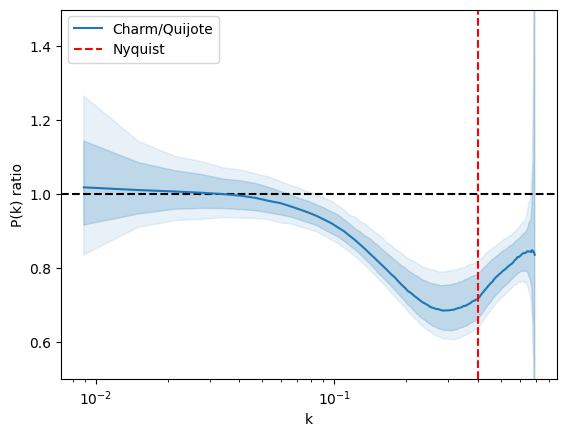

In [54]:
x1 = cPks[...,0]
x2 = qPks[...,0]
y = np.median(x1/x2, axis=0)
yerr = np.percentile(x1/x2, [5, 16, 84, 95], axis=0)
nyq = 2*np.pi/1000 * (128/2)
f, ax = plt.subplots()
ax.semilogx()
ax.axhline(1, c='k', ls='--')
ax.plot(ck, y, label='Charm/Quijote', c='C0')
ax.fill_between(ck, yerr[0], yerr[3], alpha=0.1, color='C0')
ax.fill_between(ck, yerr[1], yerr[2], alpha=0.2, color='C0')
ax.axvline(nyq, c='r', ls='--', label='Nyquist')
ax.legend()
ax.set(xlabel='k', ylabel='P(k) ratio')
ax.set_ylim(0.5,1.5)

## HOD constraints